In [11]:
using LinearAlgebra
using Distributions
using Random
using SparseArrays
using JLD2
include("../Inversion/Plot.jl")
include("../Inversion/KalmanInversion.jl")
include("../Inversion/RWMCMC.jl")
include("Darcy-1D.jl")

plot_field (generic function with 2 methods)

# 1D Darcy Flow

The equation describes the pressure field $p(x)$ in a porous medium defined by a positive random permeability field $a(x,\theta)$:

$$
    -\frac{d}{dx}\Big(a(x, \theta) \frac{d}{dx}p(x)\Big) = f(x), \qquad x\in[0,1].
$$

Here  Dirichlet boundary conditions on the pressure are applied with $p(0) = 0$ and $p(1) = 0$, and $f$ defines the source of the fluid:

$$
    f(x) = \begin{cases}
              1000 & 0 \leq x \leq \frac{1}{2}\\
              2000 & \frac{1}{2} < x \leq 1\\
            \end{cases}. 
$$

The equation is solved by the finite difference method, where computational domain is discretized by the following uniform grid:

$$0 = x_1 < x_2 < x_3 \cdots x_{N} =1 \quad \textrm{with} \quad x_i = \frac{i-1}{N-1}$$

The discretized equation becomes

\begin{align}  
f_i &= -\nabla (a \nabla p) (x_i) \\
    &= -\frac{a_{i+0.5}\nabla p_{i+0.5} - a_{i-0.5} \nabla p_{i-0.5}}{\Delta x} \\
    &= -\frac{a_{i+0.5}\frac{p_{i+1} - p_{i}}{\Delta x} - a_{i-0.5}\frac{p_{i} - p_{i-1}}{\Delta x}}{\Delta x}\\
    &= -\frac{a_{i+0.5}}{\Delta x^2} p_{i+1} + \frac{a_{i+0.5} + a_{i-0.5}}{\Delta x^2} p_{i}
    - \frac{a_{i-0.5}}{\Delta x^2}  p_{i-1}\\
    &= -\frac{a_{i} + a_{i+1}}{2\Delta x^2} p_{i+1} + \frac{a_{i+1} + 2a_{i} + a_{i-1}}{2\Delta x^2}p_{i} 
    - \frac{a_{i} + a_{i-1}}{2\Delta x^2}  p_{i-1}
\end{align}

Finally, we have the following $N-2$ dimensional tridiagonal linear system

$$ 
A \vec{p} = \vec{f}
$$
where 
$$
\vec{A} = \begin{bmatrix}
\frac{a_{3} + 2a_{2} + a_{1}}{2\Delta x^2} &  - \frac{a_{3} + a_{2}}{2\Delta x^2}  & & &\\
- \frac{a_{3} + a_{2}}{2\Delta x^2}          & \frac{a_{4} + 2a_{3} + a_{2}}{2\Delta x^2} &-\frac{a_{4} + a_{3}}{2\Delta x^2}  & &\\
                               &         - \frac{a_{4} + a_{3}}{2\Delta x^2}          & \frac{a_{5} + 2a_{4} + a_{3}}{2\Delta x^2} & - \frac{a_{5} + a_{4}}{2\Delta x^2}  &\\
                                     & &            \ddots& \ddots& \ddots \\
                                   & & &     - \frac{a_{N-1} + a_{N-2}}{2\Delta x^2}         &\frac{a_{N} + 2a_{N-1} + a_{N-2}}{2\Delta x^2}
\end{bmatrix}
\quad 
\vec{p} = \begin{bmatrix}
p_2\\
p_3\\
p_4\\
\vdots\\
p_{N-1}\\
\end{bmatrix}
\quad 
\vec{f} = \begin{bmatrix}
f(x_2)\\
f(x_3)\\
f(x_4)\\
\vdots\\
f(x_{N-1})\\
\end{bmatrix}
$$



## Random log-Gaussian Field

Assuming that $\log a(x, \theta)$ is a centred Gaussian with covariance 
$$\mathsf{C} = (-\Delta + \tau^2 )^{-d};$$
here $-\Delta$ denotes the Laplacian on $D$ subject to homogeneous Neumann boundary conditions on the space of spatial-mean zero functions, 
$\tau > 0$ denotes the inverse length scale of the random field and $d  > 0$ determines its regularity.
The Gaussian field can be represented by the Karhunen–Loève (KL) expansion

$$
    \log a(x,\theta) = \sum_{l=1}^{+\infty} \theta_{(l)}\sqrt{\lambda_l} \psi_l(x),
$$

and the eigenpairs of $\mathsf{C}$ are of the form
\begin{equation*}
    \psi_l(x) = \sqrt{2}\cos(\pi l x) \quad \textrm{ and }
                 \quad \lambda_l = (\pi^2 l^2 + \tau^2)^{-d},
\end{equation*}
and $\theta_{(l)} \sim \mathcal{N}(0,1)$ i.i.d. 

The log-Gaussian fields generated with $(d, \tau) = (1, 3), (2, 3), (2, 2)$ and approximated by the first $N_l = 10$ and $N_l =100$ KL modes are:

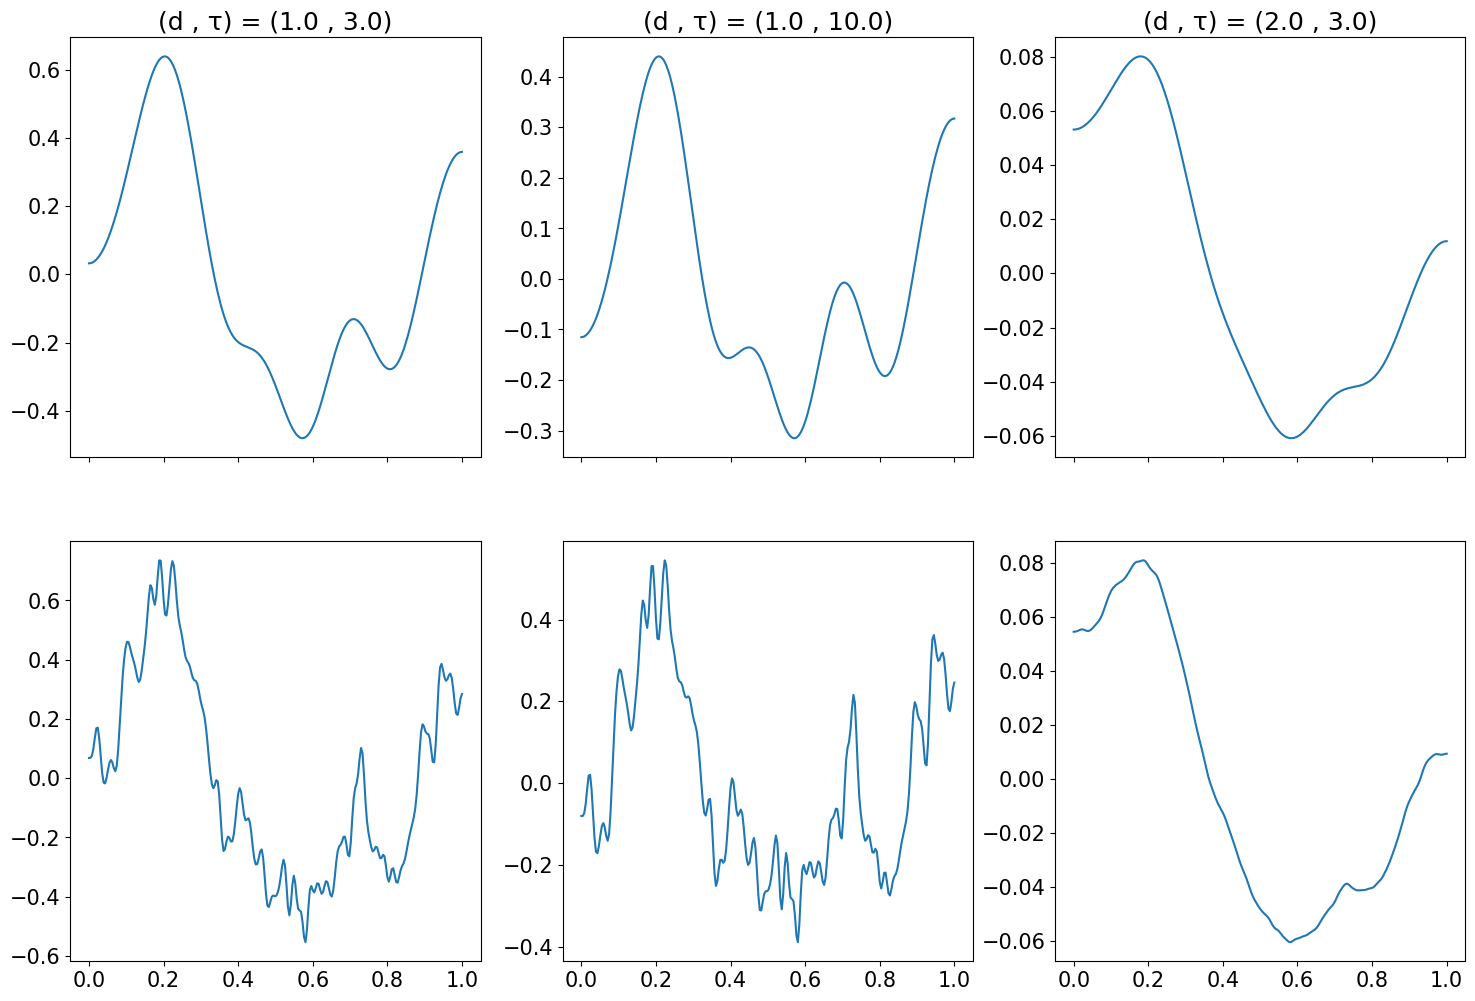

In [12]:
N_x, L = 256, 1.0
obs_ΔN = 16


fig, ax = PyPlot.subplots(ncols=3, nrows=2, sharex=true, sharey=false, figsize=(18,12))

N_KLs = (10,100)
d_τ_paris = ((1.0,3.0), (1.0,10.0), (2.0,3.0))
for i = 1:2
    N_KL = N_KLs[i]
    for j = 1:3
        d, τ = d_τ_paris[j]
        N_θ = N_KL
        darcy = Setup_Param(N_x, L, N_KL, obs_ΔN, N_θ, d, τ; seed=11)
        ax[i,j].plot(darcy.xx, darcy.logκ)
        if i == 1
            ax[i,j].set_title("(d , τ) = ("*string(d)*" , "*string(τ)*")")
        end
    end
end

## Inverse problem 
For the inverse problem, we generate a truth random field $\log a(x,\theta_{ref})$ with $N_{\theta} = 32$ and $\theta_{ref} \sim \mathcal{N}(0, I^{32})$, which consists of the first $32$ KL modes. 
The observation $y_{ref}$ consists of pointwise measurements of the pressure value $p(x)$ at $63$ equidistant points in the domain, with the observation error $\eta \sim \mathcal{N}(0, 0.1^2 I)$. 
The forward problem is solved by the finite difference method with $512$ grid points. 

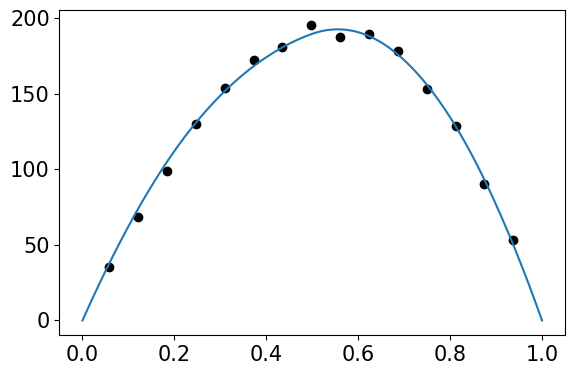

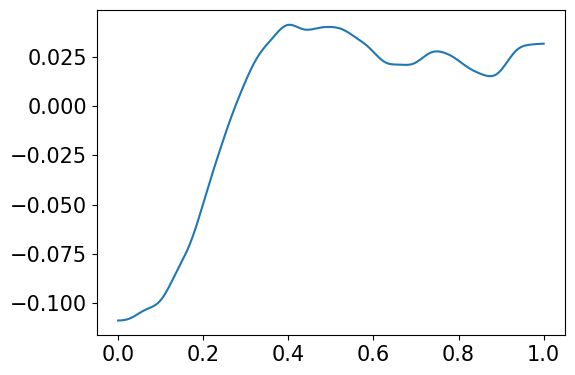

In [13]:
N_x, L = 256, 1.0
obs_ΔN = 16
d = 2.0
τ = 3.0
N_KL = N_θ = 32
θ_ind = Array(1:N_θ)
darcy = Setup_Param(N_x, L, 
N_KL, obs_ΔN, 
N_θ, d, τ)
N_y = darcy.N_y

θ_ref = darcy.θ_ref
κ = exp.(darcy.logκ)
h = solve_Darcy_1D(darcy, κ)

# observation
ση = 2.0
y_noiseless = compute_obs(darcy, h)
y = copy(y_noiseless)
Random.seed!(123);
for i = 1:length(y)
    # noise = rand(Normal(0, noise_level*y[i]))
    noise = rand(Normal(0, ση^2))
    y[i] += noise
end

PyPlot.figure(figsize=(6,4))
plot_field(darcy, h, true, "Darcy-1D-obs.pdf"; y_obs = y)
PyPlot.figure(figsize=(6,4))
plot_field(darcy, darcy.logκ, false, "Darcy-1D-logk.pdf")


## Unscented Kalman Inversion

The UKI is initialized at $\theta_0\sim\mathcal{N}(0, I)$  

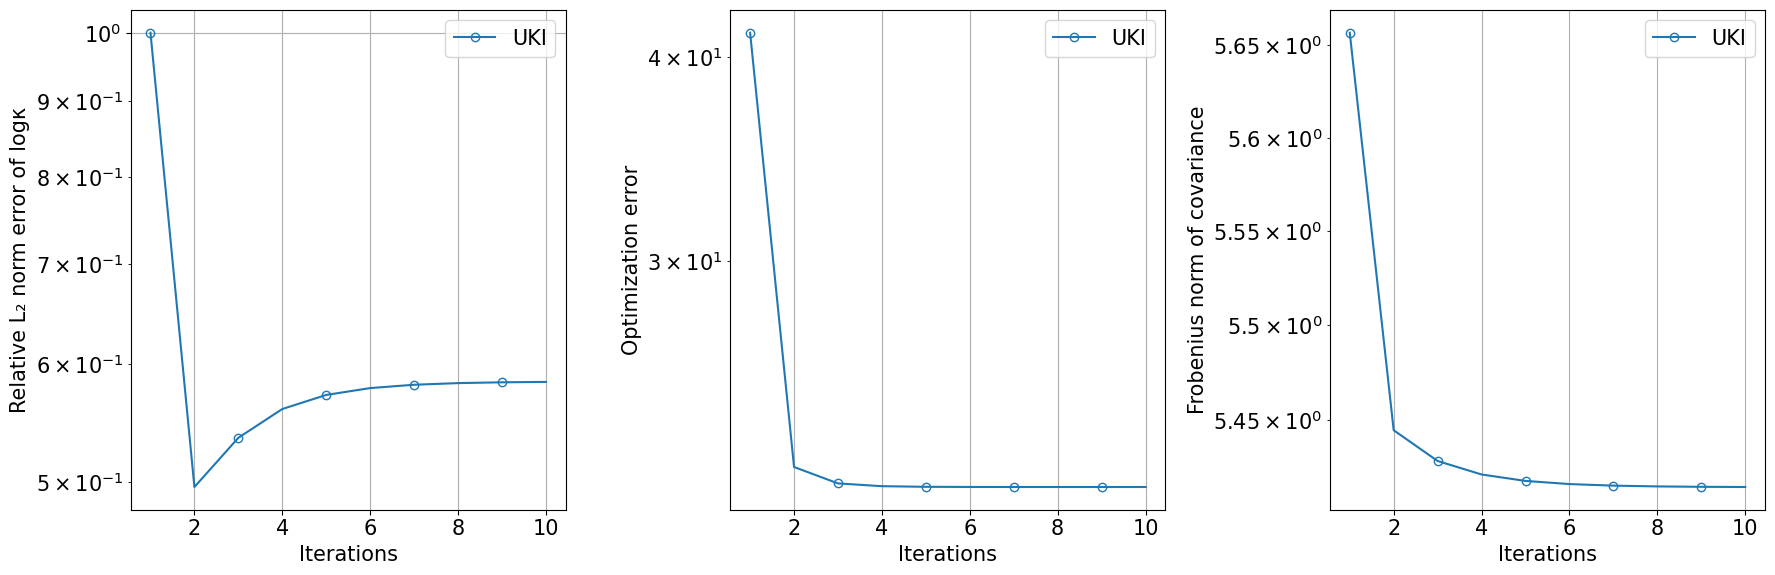

┌ Info: ((47,), (47, 47))
└ @ Main In[14]:7
┌ Info: Start UKI on the mean-field stochastic dynamical system for Bayesian inference 
└ @ Main /Users/huang/Desktop/Code/InverseProblems-master.jl/Inversion/KI.jl:469


In [14]:
Σ_η = Array(Diagonal(fill(ση^2, N_y)))
Σ0 = Array(Diagonal(fill(1.0^2.0, N_θ)))

aug_y = [y; zeros(Float64, N_θ)] 
aug_Σ_η = [Σ_η zeros(Float64, N_y, N_θ); zeros(Float64, N_θ, N_y) Σ0]  
darcy.N_y += N_θ
@info size(aug_y), size(aug_Σ_η)
# UKI 
θ0_mean = zeros(Float64, N_θ) 
θθ0_cov = Σ0
N_iter = 10
α_reg = 1.0
update_freq = 1
γ = 1.0
ukiobj = UKI_Run(darcy, aug_forward, θ0_mean, θθ0_cov, θ0_mean, θθ0_cov, aug_y, aug_Σ_η, γ,  α_reg, update_freq, N_iter)


fig, (ax1, ax2, ax3) = PyPlot.subplots(ncols=3, figsize=(18,6))
ites = Array(LinRange(1, N_iter, N_iter))
errors = zeros(Float64, (3, N_iter))
for i = 1:N_iter
    errors[1, i] = norm(darcy.logκ - compute_logκ(darcy, ukiobj.θ_mean[i]))/norm(darcy.logκ)
    errors[2, i] = 0.5*(ukiobj.y_pred[i] - ukiobj.y)'*(ukiobj.Σ_η\(ukiobj.y_pred[i] - ukiobj.y))
    errors[3, i] = norm(ukiobj.θθ_cov[i])
end

ax1.semilogy(ites, errors[1, :], "-o", fillstyle="none", markevery=2, label= "UKI")
ax1.set_xlabel("Iterations")
ax1.set_ylabel("Relative L₂ norm error of logκ")
ax1.legend()
ax1.grid(true)

ax2.semilogy(ites, errors[2, :], "-o", fillstyle="none", markevery=2, label= "UKI")
ax2.set_xlabel("Iterations")
ax2.set_ylabel("Optimization error")
ax2.grid(true)
ax2.legend()

ax3.semilogy(ites, errors[3, :], "-o", fillstyle="none", markevery=2, label= "UKI")
ax3.set_xlabel("Iterations")
ax3.set_ylabel("Frobenius norm of covariance")
ax3.grid(true)
ax3.legend()
fig.tight_layout()
fig.savefig("Darcy-1D-Loss.pdf")


## Random Walk Metropolis Algorithm

The reference posterior distribution is approximated by the Random Walk Metropolis Algorithm (MCMC) 
with $2\times 10^8$ samples (with a $10^8$ sample burn-in period). 
The prior is $\mathcal{N}(0, 10^2 I)$, where the covariance is large, and therefore the prior is almost uninformative.
In order to accelerate the convergence of MCMC, 
we initialize the sampling with $\theta_{ref}$ and choose a step size $10^{-3}$. 
For the UKI, the initial condition is $\theta_0 \sim \mathcal{N}(0, I)$. 

⚠️ It takes 10 hours!

In [16]:
# compute posterior distribution by MCMC
# (uninformative) prior mean and covariance
μ0 =  θ0_mean # θ_ref #
Σ0 = Array(Diagonal(fill(1.0^2.0, N_θ)))

log_likelihood_func(θ) = log_likelihood(darcy, θ, forward, y,  Σ_η)
N_iter_MCMC , n_burn_in= 2*10^8, 5*10^7
# us = PCN_Run(log_likelihood_func, μ0, Σ0, 0.04, N_iter_MCMC)


(200000000, 50000000)

The estimated KL expansion parameters $\{\theta_{(i)}\}$ for the log-permeability field and the associated  3-$\sigma$ confidence intervals  obtained by the UKI at the 20th iteration and MCMC are depicted. Both UKI and MCMC converge to the true value $\theta_{ref}$, and the covariance estimations for each parameter match well with each other. 

In [17]:
uki_θ_mean  = ukiobj.θ_mean[end]
uki_θθ_cov = ukiobj.θθ_cov[end]
uki_θθ_std = sqrt.(diag(ukiobj.θθ_cov[end]))

θ_cov_ind = Array(1:div(N_θ*(N_θ+1), 2))
uki_θiθj_cov, mcmc_θiθj_cov = zeros(Float64, div(N_θ*(N_θ+1), 2)), zeros(Float64, div(N_θ*(N_θ+1), 2))

PCN_RUN = true
if PCN_RUN
    mcmc_θ_mean = mean(us[n_burn_in:N_iter_MCMC, :], dims=1)[:]
    mcmc_θθ_std = std(us[n_burn_in:N_iter_MCMC, :], dims=1)[:]

    ind_ij = 1
    for i = 1:N_θ
        for j = i:N_θ
            global ind_ij
            uki_θiθj_cov[ind_ij]   = uki_θθ_cov[i,j]
            mcmc_θiθj_cov[ind_ij] = (us[n_burn_in:N_iter_MCMC, i] .- mcmc_θ_mean[i])' * (us[n_burn_in:N_iter_MCMC, j] .- mcmc_θ_mean[j])/(N_iter_MCMC - n_burn_in)

            ind_ij += 1
        end
    end
    @save "Darcy-1D.jld2" mcmc_θ_mean  mcmc_θθ_std mcmc_θiθj_cov
else
    ind_ij = 1
    for i = 1:N_θ
        for j = i:N_θ
            global ind_ij
            uki_θiθj_cov[ind_ij]   = uki_θθ_cov[i,j]
            ind_ij += 1
        end
    end
    @load "Darcy-1D.jld2" mcmc_θ_mean  mcmc_θθ_std mcmc_θiθj_cov
    
end



┌ Warning: Opening file with JLD2.MmapIO failed, falling back to IOStream
└ @ JLD2 /Users/huang/.julia/packages/JLD2/AilrO/src/JLD2.jl:230


LoadError: SystemError: opening file "Darcy-1D.jld2": No such file or directory

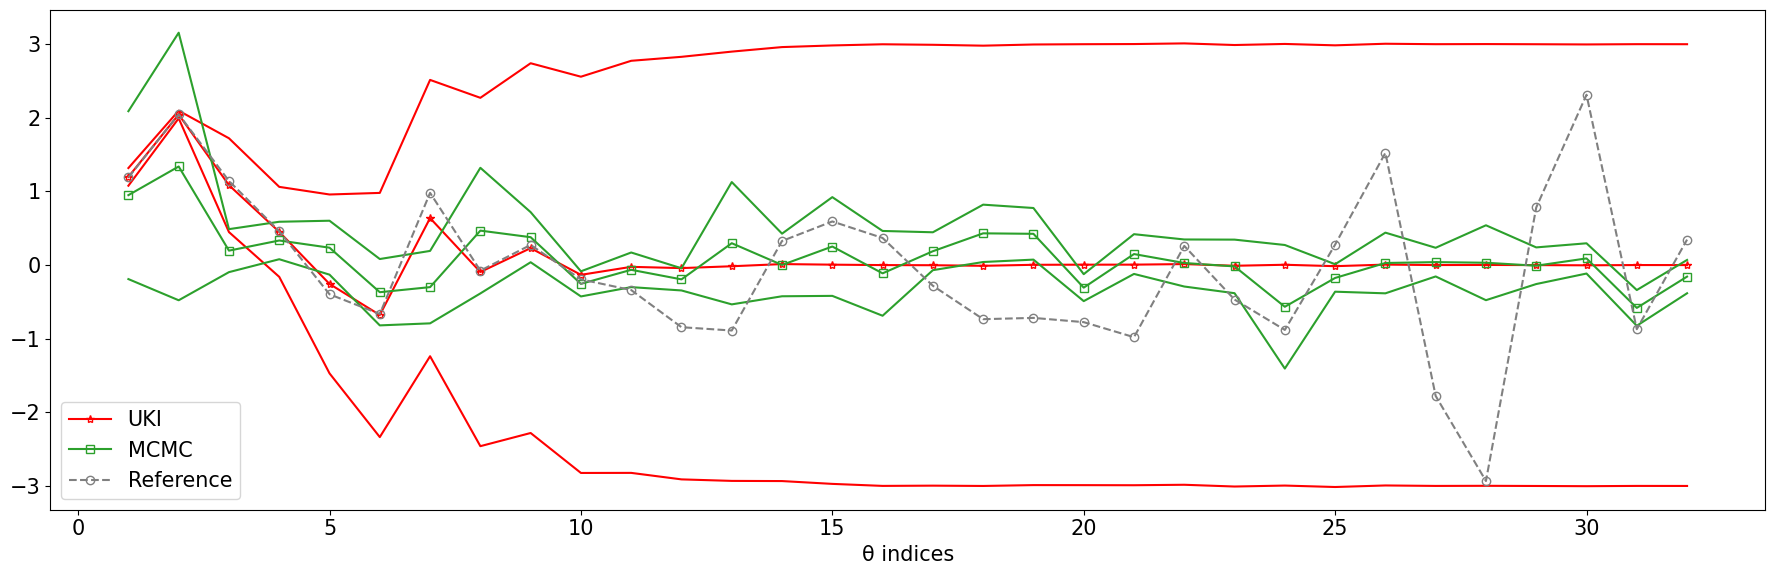

In [14]:
fig, ax = PyPlot.subplots(figsize=(18,6))
ax.plot(θ_ind , uki_θ_mean,"-*", color="red", fillstyle="none",  label="UKI")
ax.plot(θ_ind , uki_θ_mean + 3.0*uki_θθ_std, color="red")
ax.plot(θ_ind , uki_θ_mean - 3.0*uki_θθ_std, color="red")



ax.plot(θ_ind , mcmc_θ_mean,"-s", color="C2", fillstyle="none" , label="MCMC")
ax.plot(θ_ind , mcmc_θ_mean + 3.0*mcmc_θθ_std, color ="C2")
ax.plot(θ_ind , mcmc_θ_mean - 3.0*mcmc_θθ_std, color ="C2")


ax.plot(θ_ind , θ_ref, "--o", color="grey", fillstyle="none", label="Reference")
ax.legend()
# plot MCMC results 
ax.set_xlabel("θ indices")
fig.tight_layout()
fig.savefig("Darcy-1D-theta.pdf")

The covariance for each pair ($\theta_{(i)},  \theta_{(j)}$) with $i \leq j$ obtained 
by UKI and MCMC are depicted. These pairs are sorted in an ascent order by comparing 
the first element and then the second. 
The UKI and MCMC deliver very similar covariance estimations.

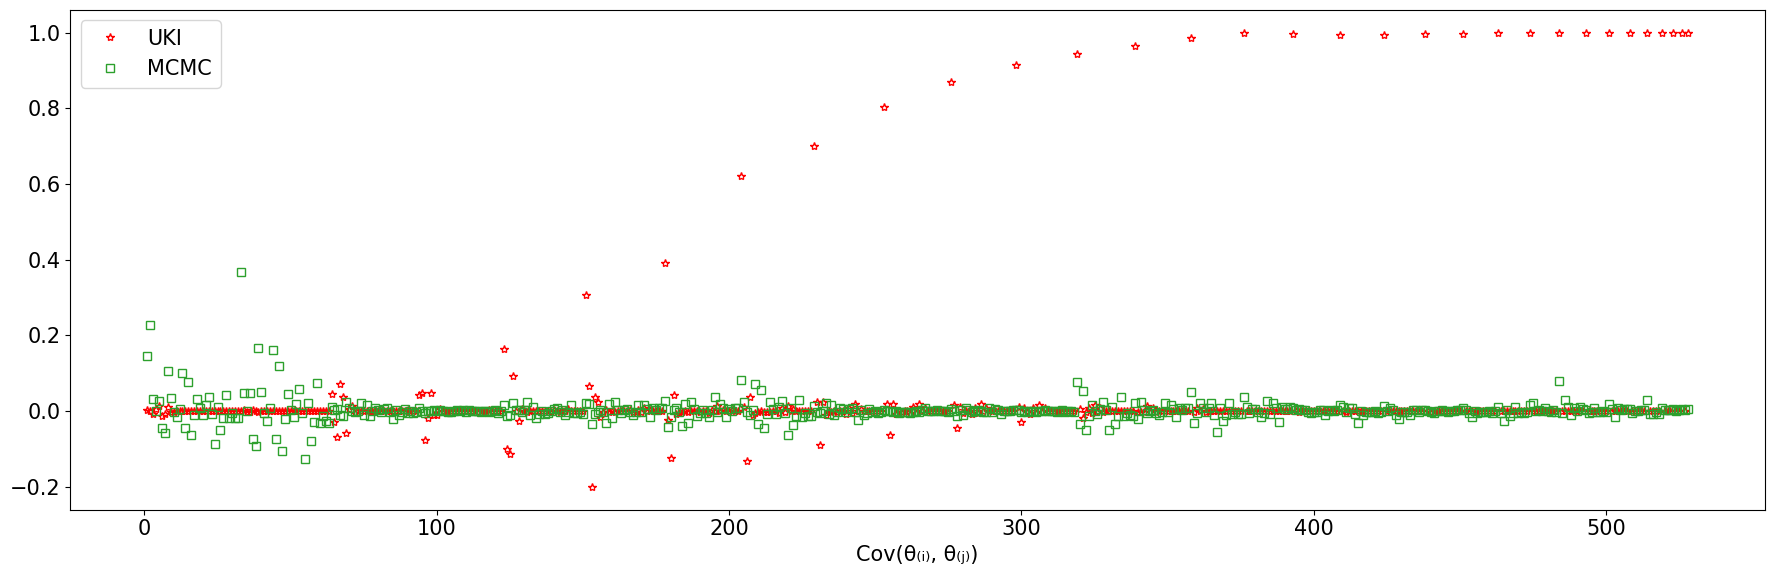

In [15]:
fig, ax = PyPlot.subplots(figsize=(18,6))
ax.plot(θ_cov_ind , uki_θiθj_cov,  "*", color="red", fillstyle="none",  label="UKI")
ax.plot(θ_cov_ind , mcmc_θiθj_cov, "s", color="C2",  fillstyle="none" , label="MCMC")


ax.legend()
# plot MCMC results 
ax.set_xlabel("Cov(θ₍ᵢ₎, θ₍ⱼ₎)")
fig.tight_layout()
fig.savefig("Darcy-1D-cov.pdf")

